In [ ]:
%matplotlib inline


DCGAN
==============

This notebook was taken from `Nathan Inkawhich <https://github.com/inkawhich>`__




# Importing libraries

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Defining the inputs and hyperparameters

In [3]:
# Root directory for dataset
dataroot = "/home/ubuntu/facebook/datasets/celeba"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Loading CIFAR-10 Dataset

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


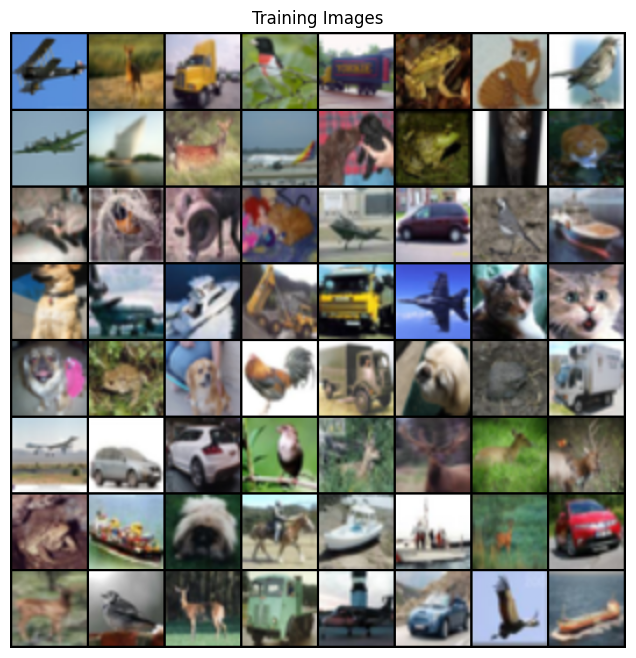

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
import torchvision
import torchvision.datasets as dset

dataroot="/content/drive/MyDrive/Cifar-10/cifar10/cifar-10-batches-py"
# Use CIFAR10 dataset instead of ImageFolder
dataset = torchvision.datasets.CIFAR10(root=dataroot,
                                       train=True,
                                       download=True,  # Since you already have it
                                       transform=transforms.Compose([
                                           transforms.Resize(image_size),
                                           transforms.CenterCrop(image_size),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Loading the trained checkpoints and performing Diversity test

Set random seed to 42 for reproducible results
Using device: cpu
Checkpoint loaded successfully from: /content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth
Training epoch: 70
Generator loaded successfully!
Architecture: nz=100, ngf=64, nc=3
Generated latent vectors shape: torch.Size([100, 100, 1, 1])
Latent vector range: [-3.746, 3.817]

LATENT VECTORS:

Latent Vector 1:
Shape: torch.Size([100, 1, 1])
First 10 values: [-0.25208607  1.3950613   0.5603078  -0.65692794 -1.6711837  -1.4144932
 -1.2643857   0.5002061  -0.24135795 -2.5936038 ]
Last 10 values: [-0.28867555  2.4552612   1.5039197  -1.3081776  -0.6756909   1.2603115
  0.11611147  0.19171181 -0.30529755 -0.06996524]
Mean: -0.0487, Std: 0.9961
Min: -2.5936, Max: 2.4553
--------------------------------------------------

Latent Vector 2:
Shape: torch.Size([100, 1, 1])
First 10 values: [-0.10270829 -1.4345818  -0.9948659  -0.77567554  0.41423786  0.7452114
 -0.75348705 -1.9056408   0.04149207  1.4194232 ]
Last 10 values: [

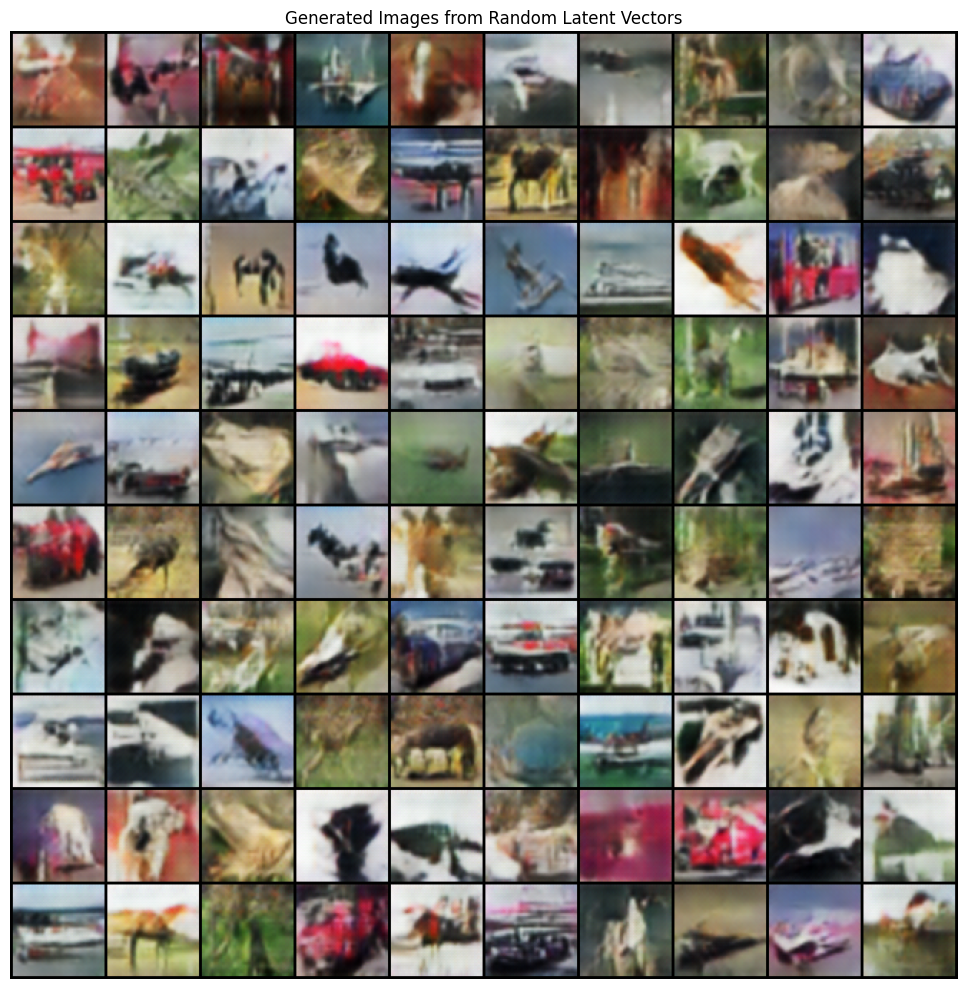


GENERATION SUMMARY
Number of images generated: 100
Latent vector shape: torch.Size([100, 100, 1, 1])
Generated image shape: torch.Size([100, 3, 64, 64])
Device used: cpu
Latent vectors saved: /content/drive/MyDrive/GAN_Checkpoints/Latent_space/generated_latent_vectors.pt
Images saved in: /content/drive/MyDrive/GAN_Checkpoints/gen_output_images/generated_images
Grid image: /content/drive/MyDrive/GAN_Checkpoints/gen_output_images/generated_images_grid.png

LATENT VECTOR STATISTICS:
  Mean: 0.0235
  Std: 1.0013
  Min: -3.7456
  Max: 3.8175

GENERATED IMAGE STATISTICS:
  Mean: -0.0128
  Std: 0.4312
  Min: -0.9189
  Max: 0.9670


In [9]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

def load_and_generate_images():
    """Load GAN generator and generate 20 images from random latent vectors"""

    # Set seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print(f"Set random seed to {seed} for reproducible results")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the checkpoint
    checkpoint_path = "/content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth"

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print(f"Checkpoint loaded successfully from: {checkpoint_path}")
        print(f"Training epoch: {checkpoint['epoch']}")

        # Create generator with inferred parameters
        # From state_dict: main.0.weight: torch.Size([100, 512, 4, 4])
        # This means: nz=100 (latent dim), ngf*8=512 so ngf=64
        nz = 100  # Latent dimension
        ngf = 64  # Generator feature maps
        nc = 3    # Number of channels (RGB)

        # Create and load generator
        netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netG.eval()

        print(f"Generator loaded successfully!")
        print(f"Architecture: nz={nz}, ngf={ngf}, nc={nc}")

    except Exception as e:
        print(f"Error loading generator: {e}")
        return None, None

    # Generate 20 random latent vectors
    num_images = 100

    # Generate random latent vectors from standard normal distribution
    # Shape: [batch_size, nz, 1, 1] for DCGAN
    latent_vectors = torch.randn(num_images, nz, 1, 1, device=device)

    print(f"Generated latent vectors shape: {latent_vectors.shape}")
    print(f"Latent vector range: [{latent_vectors.min():.3f}, {latent_vectors.max():.3f}]")

    # Print all latent vectors
    print("\nLATENT VECTORS:")
    print("="*70)

    for i in range(latent_vectors.shape[0]):
        print(f"\nLatent Vector {i+1}:")
        print(f"Shape: {latent_vectors[i].shape}")

        # Print the actual values (flattened for readability)
        vector_flat = latent_vectors[i].flatten()
        print(f"First 10 values: {vector_flat[:10].cpu().numpy()}")
        print(f"Last 10 values: {vector_flat[-10:].cpu().numpy()}")

        # Print statistics for this vector
        print(f"Mean: {vector_flat.mean():.4f}, Std: {vector_flat.std():.4f}")
        print(f"Min: {vector_flat.min():.4f}, Max: {vector_flat.max():.4f}")

        if i < 19:  # Add separator between vectors
            print("-" * 50)

    # Compact format summary
    print("\n\nCOMPACT SUMMARY:")
    print("="*70)
    for i in range(latent_vectors.shape[0]):
        vector_flat = latent_vectors[i].flatten()
        print(f"Vector {i+1:2d}: [{vector_flat[0]:.3f}, {vector_flat[1]:.3f}, {vector_flat[2]:.3f}, ..., {vector_flat[-1]:.3f}] (mean: {vector_flat.mean():.3f})")

    # Generate images
    with torch.no_grad():
        generated_images = netG(latent_vectors)
        print(f"\nGenerated images shape: {generated_images.shape}")
        print(f"Generated images range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")

    # Save latent vectors
    latent_save_path = "/content/drive/MyDrive/GAN_Checkpoints/Latent_space/generated_latent_vectors.pt"
    torch.save(latent_vectors.cpu(), latent_save_path)
    print(f"Latent vectors saved to: {latent_save_path}")

    # Save generated images as individual files
    output_dir = "/content/drive/MyDrive/GAN_Checkpoints/gen_output_images/generated_images"
    os.makedirs(output_dir, exist_ok=True)

    # Save each image individually
    for i in range(num_images):
        image_path = f"{output_dir}/generated_image_{i+1:02d}.png"
        vutils.save_image(generated_images[i], image_path, normalize=True)

    print(f"Individual images saved to: {output_dir}")

    # Create and save a grid of all images
    grid_path = "/content/drive/MyDrive/GAN_Checkpoints/gen_output_images/generated_images_grid.png"
    grid = vutils.make_grid(generated_images, nrow=10, normalize=True, padding=2)
    vutils.save_image(grid, grid_path)
    print(f"Image grid saved to: {grid_path}")

    # Display the grid
    plt.figure(figsize=(12, 10))
    plt.axis("off")
    plt.title("Generated Images from Random Latent Vectors")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("GENERATION SUMMARY")
    print("="*50)
    print(f"Number of images generated: {num_images}")
    print(f"Latent vector shape: {latent_vectors.shape}")
    print(f"Generated image shape: {generated_images.shape}")
    print(f"Device used: {device}")
    print(f"Latent vectors saved: {latent_save_path}")
    print(f"Images saved in: {output_dir}")
    print(f"Grid image: {grid_path}")

    # Additional analysis
    print("\nLATENT VECTOR STATISTICS:")
    latent_flat = latent_vectors.flatten()
    print(f"  Mean: {latent_flat.mean():.4f}")
    print(f"  Std: {latent_flat.std():.4f}")
    print(f"  Min: {latent_flat.min():.4f}")
    print(f"  Max: {latent_flat.max():.4f}")

    print("\nGENERATED IMAGE STATISTICS:")
    image_flat = generated_images.flatten()
    print(f"  Mean: {image_flat.mean():.4f}")
    print(f"  Std: {image_flat.std():.4f}")
    print(f"  Min: {image_flat.min():.4f}")
    print(f"  Max: {image_flat.max():.4f}")

    return generated_images, latent_vectors

# Run the generation
generated_images, latent_vectors = load_and_generate_images()

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




# Sementic Meaning Exploration for GANs (Example One)

Checkpoint loaded successfully from: /content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth
Training epoch: 70
Exploring dimension 0


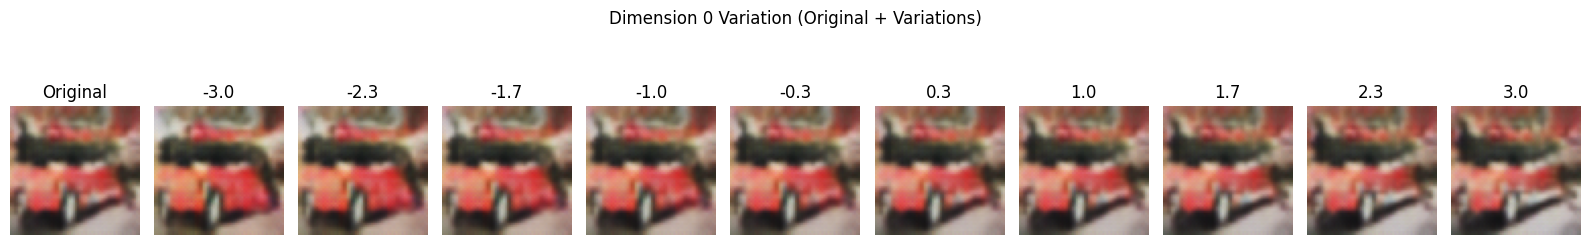

Exploring dimension 1


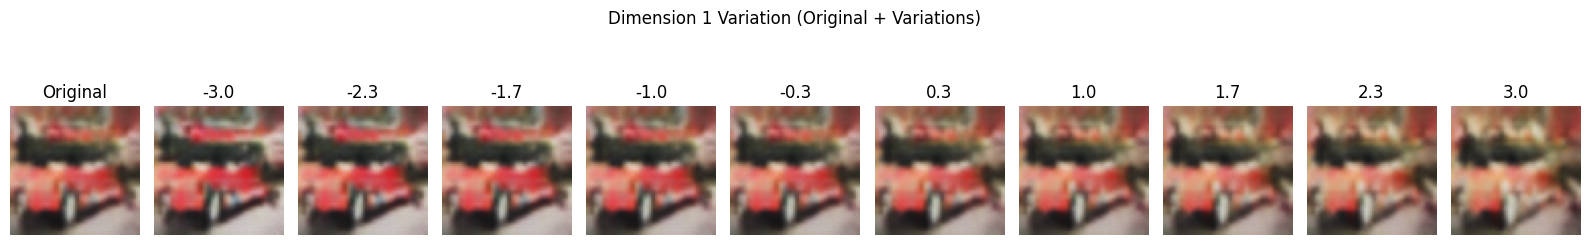

Exploring dimension 5


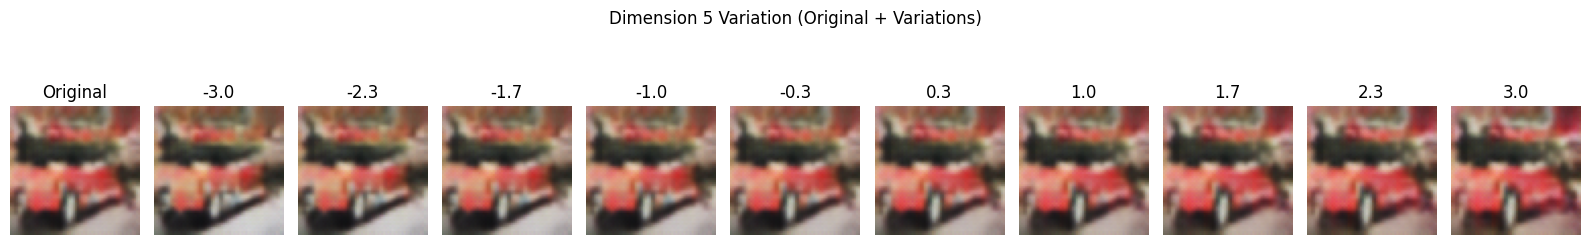

Exploring dimension 10


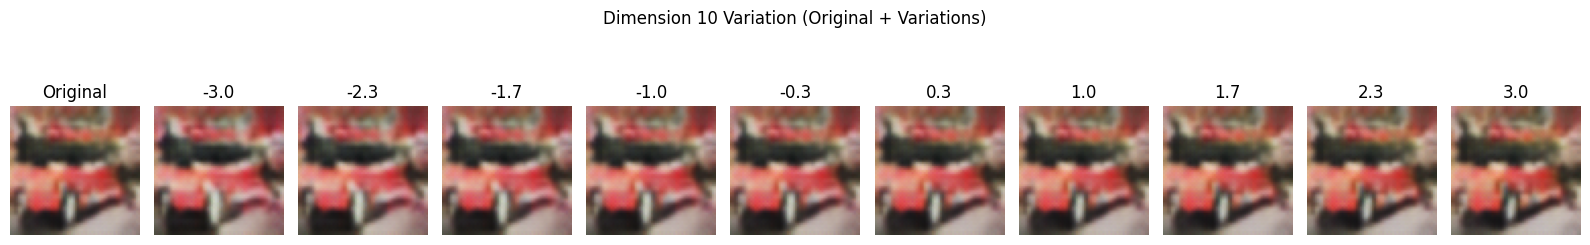

Exploring dimension 20


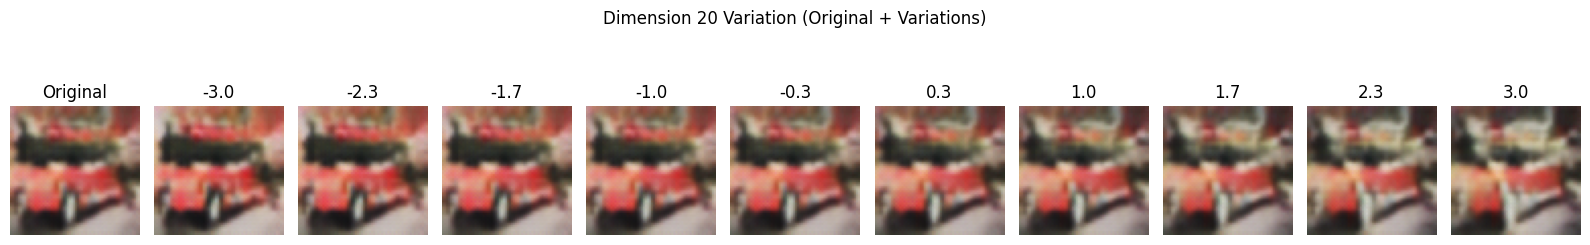

Exploring dimension 30


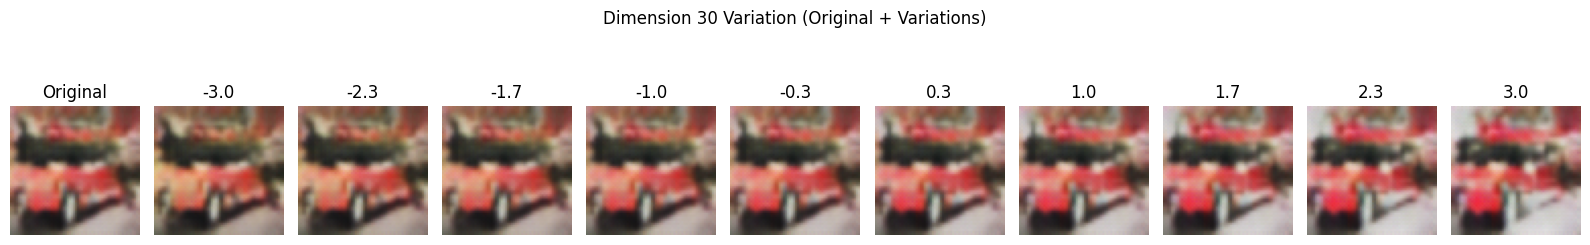

Exploring dimension 50


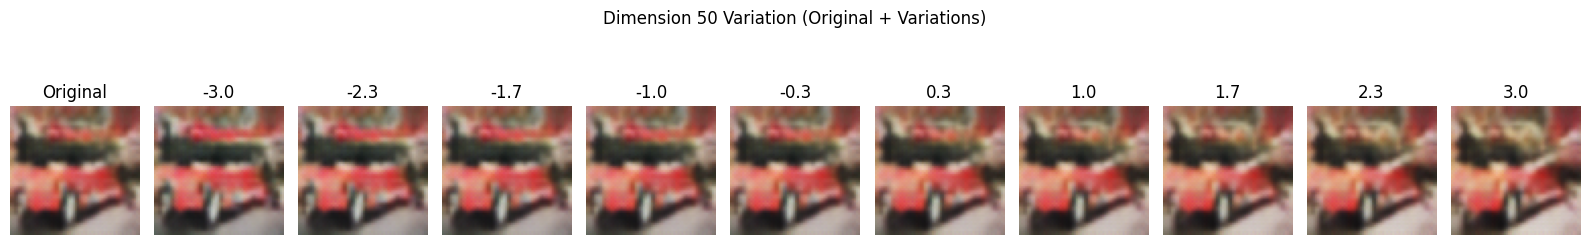

Exploring dimension 70


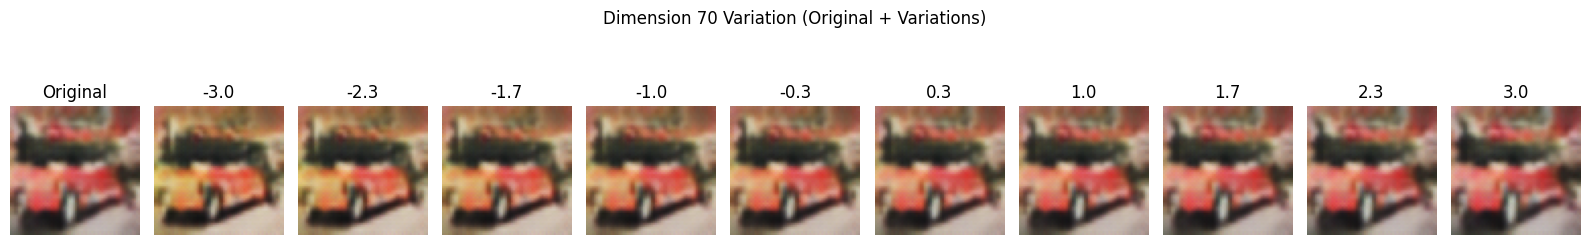

Exploring dimension 90


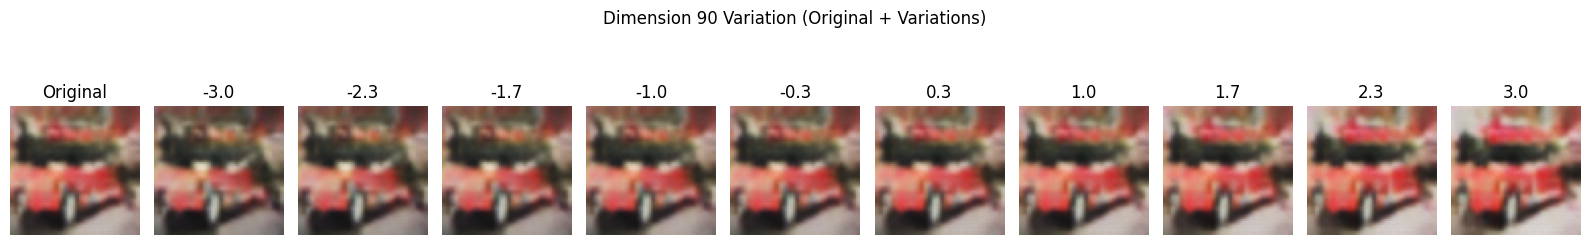

In [24]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

def explore_gan_latent_dimensions(netG, device, nz=100, num_variations=10, dim_range=3.0):
    """
    Explore semantic meaning of individual latent dimensions
    """
    netG.eval()

    # Fix a base latent vector - note the shape for your generator
    base_z = torch.randn(1, nz, 1, 1, device=device)  # Shape: [1, 100, 1, 1]

    # Test multiple dimensions
    dimensions_to_test = [0, 1, 5, 10, 20, 30, 50, 70, 90]

    for dim_idx in dimensions_to_test:
        print(f"Exploring dimension {dim_idx}")

        # Create variations by changing only one dimension
        z_variations = base_z.repeat(num_variations, 1, 1, 1)  # [num_variations, 100, 1, 1]

        # Vary the specific dimension from -dim_range to +dim_range
        variation_values = torch.linspace(-dim_range, dim_range, num_variations)
        z_variations[:, dim_idx, 0, 0] = variation_values  # Note the indexing change

        # Generate images
        with torch.no_grad():
            generated_images = netG(z_variations)

        # Plot results
        plt.figure(figsize=(16, 3))

        # First subplot: show original image (no variation)
        plt.subplot(1, num_variations + 1, 1)
        with torch.no_grad():
            original_img = netG(base_z)[0].cpu()
            original_img = (original_img + 1) / 2
            original_img = original_img.permute(1, 2, 0)
        plt.imshow(original_img)
        plt.title('Original')
        plt.axis('off')

        # Rest of subplots: show variations
        for i in range(num_variations):
            plt.subplot(1, num_variations + 1, i + 2)  # +2 because original takes first slot
            img = generated_images[i].cpu()
            img = (img + 1) / 2
            img = img.permute(1, 2, 0)
            plt.imshow(img)
            plt.title(f'{variation_values[i]:.1f}')
            plt.axis('off')

        plt.suptitle(f'Dimension {dim_idx} Variation (Original + Variations)')
        plt.tight_layout()
        plt.show()
# Run exploration
checkpoint_path = "/content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"Checkpoint loaded successfully from: {checkpoint_path}")
print(f"Training epoch: {checkpoint['epoch']}")

# Create generator with inferred parameters
# From state_dict: main.0.weight: torch.Size([100, 512, 4, 4])
# This means: nz=100 (latent dim), ngf*8=512 so ngf=64
nz = 100  # Latent dimension
ngf = 64  # Generator feature maps
nc = 3    # Number of channels (RGB)

# Create and load generator
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netG.load_state_dict(checkpoint['netG_state_dict'])
explore_gan_latent_dimensions(netG, device, nz=nz)  # Adjust z_dim to your GAN's latent size

# Semantic Testing Example (Two)

Checkpoint loaded successfully from: /content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth
Training epoch: 70
Exploring dimension 0


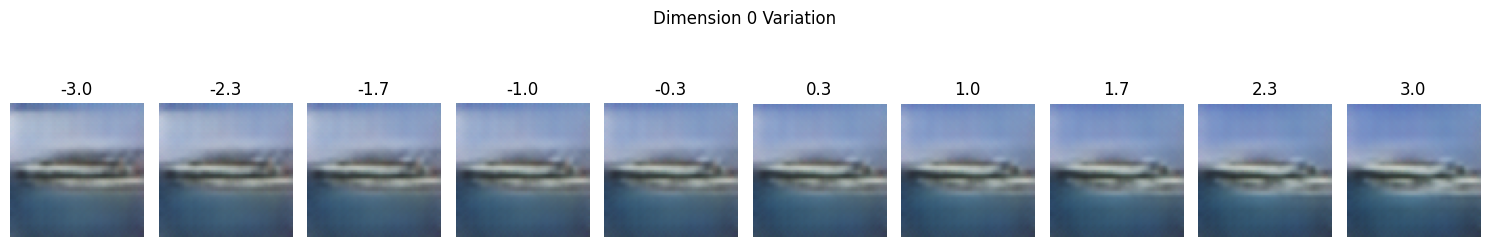

Exploring dimension 1


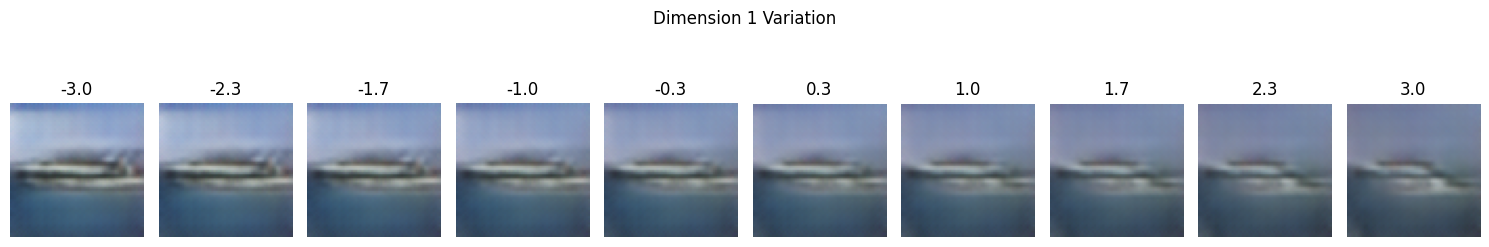

Exploring dimension 5


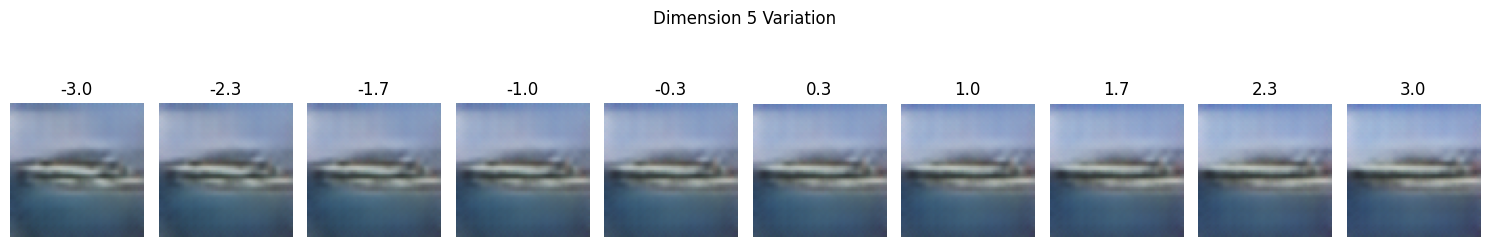

Exploring dimension 10


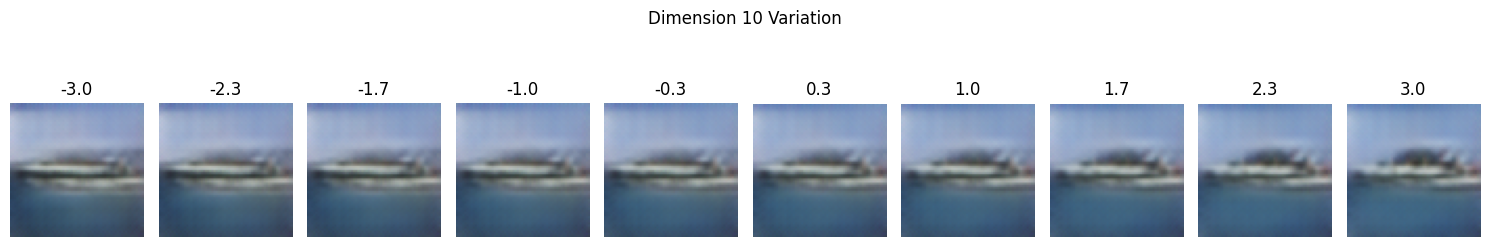

Exploring dimension 20


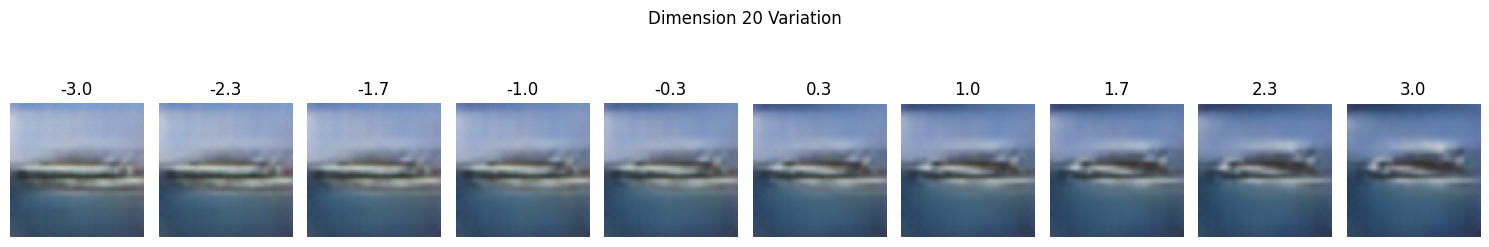

Exploring dimension 30


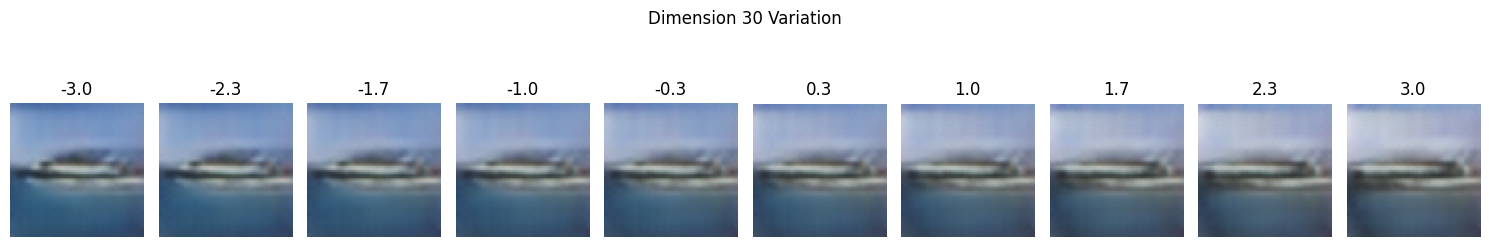

Exploring dimension 50


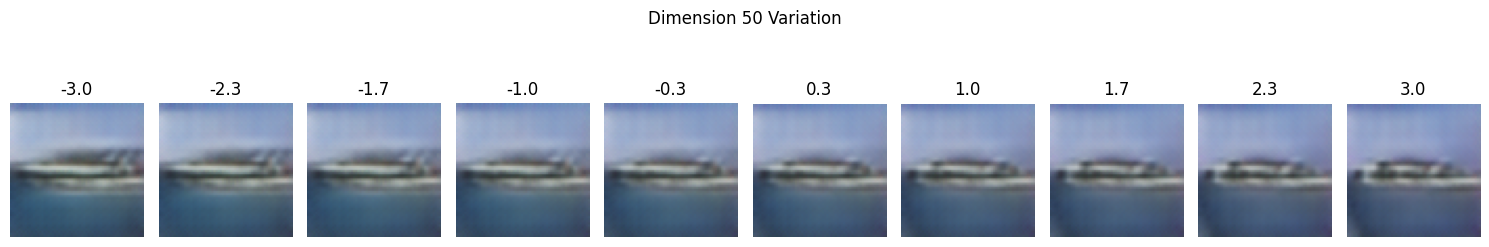

Exploring dimension 70


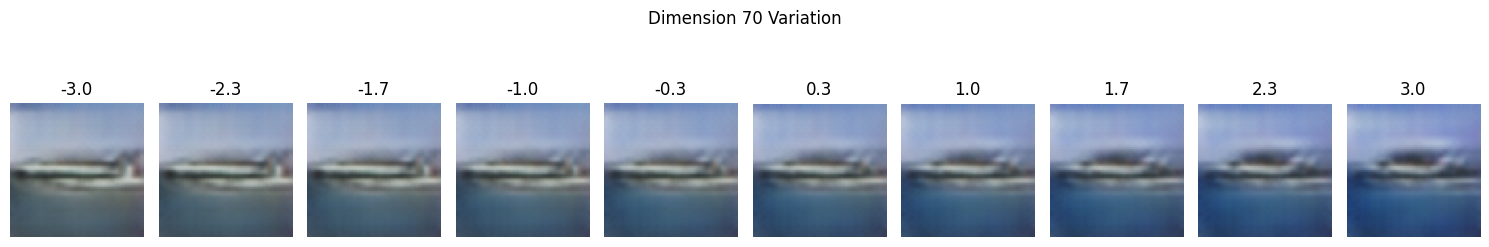

Exploring dimension 90


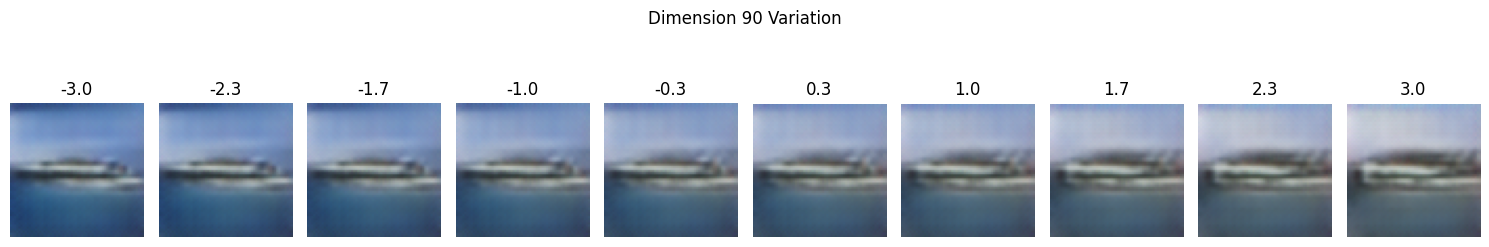

In [14]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

def explore_gan_latent_dimensions(netG, device, nz=100, num_variations=10, dim_range=3.0):
    """
    Explore semantic meaning of individual latent dimensions
    """
    netG.eval()

    # Fix a base latent vector - note the shape for your generator
    base_z = torch.randn(1, nz, 1, 1, device=device)  # Shape: [1, 100, 1, 1]

    # Test multiple dimensions
    dimensions_to_test = [0, 1, 5, 10, 20, 30, 50, 70, 90]

    for dim_idx in dimensions_to_test:
        print(f"Exploring dimension {dim_idx}")

        # Create variations by changing only one dimension
        z_variations = base_z.repeat(num_variations, 1, 1, 1)  # [num_variations, 100, 1, 1]

        # Vary the specific dimension from -dim_range to +dim_range
        variation_values = torch.linspace(-dim_range, dim_range, num_variations)
        z_variations[:, dim_idx, 0, 0] = variation_values  # Note the indexing change

        # Generate images
        with torch.no_grad():
            generated_images = netG(z_variations)

        # Plot results
        plt.figure(figsize=(16, 3))

        # First subplot: show original image (no variation)
        plt.subplot(1, num_variations + 1, 1)
        with torch.no_grad():
            original_img = netG(base_z)[0].cpu()
            original_img = (original_img + 1) / 2
            original_img = original_img.permute(1, 2, 0)
        plt.imshow(original_img)
        plt.title('Original')
        plt.axis('off')

        # Rest of subplots: show variations
        for i in range(num_variations):
            plt.subplot(1, num_variations + 1, i + 2)  # +2 because original takes first slot
            img = generated_images[i].cpu()
            img = (img + 1) / 2
            img = img.permute(1, 2, 0)
            plt.imshow(img)
            plt.title(f'{variation_values[i]:.1f}')
            plt.axis('off')

        plt.suptitle(f'Dimension {dim_idx} Variation (Original + Variations)')
        plt.tight_layout()
        plt.show()
# Run exploration
checkpoint_path = "/content/drive/MyDrive/GAN_Checkpoints/checkpoint_epoch_70.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"Checkpoint loaded successfully from: {checkpoint_path}")
print(f"Training epoch: {checkpoint['epoch']}")

# Create generator with inferred parameters
# From state_dict: main.0.weight: torch.Size([100, 512, 4, 4])
# This means: nz=100 (latent dim), ngf*8=512 so ngf=64
nz = 100  # Latent dimension
ngf = 64  # Generator feature maps
nc = 3    # Number of channels (RGB)

# Create and load generator
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netG.load_state_dict(checkpoint['netG_state_dict'])
explore_gan_latent_dimensions(netG, device, nz=nz)  # Adjust z_dim to your GAN's latent size